In [3]:
import inspect
import collections
import networkx as nx

from func2dag import utils as f2d_utils
from pome_treatment import pome_treatment as pome

In [4]:
module = pome

In [5]:
dec = inspect.getmembers(module, lambda x: isinstance(x, f2d_utils.TagDecorator))
tag_set = {f for _, f in dec}

tag_dict = collections.defaultdict(list)
for tag in tag_set:
    for f in tag.listit():
        tag_dict[f.__name__].append(tag.tag_name)

In [6]:
functions = inspect.getmembers(module, inspect.isfunction)

# filter imported functions to module
functions = [
    (fname, f) for fname, f in functions if f.__module__ == module.__name__
]

dag = nx.MultiDiGraph()
for fname,func in functions:
    func_sig = inspect.signature(func)
    
    for param in func_sig.parameters:
        #print(param,fname)
        dag.add_edge(param,
                     f2d_utils.get_fname_param(fname),
                     **{'function':func,
                        'name':f2d_utils.get_eqname_param(fname),
                        'tag':tag_dict.get(fname)}
                        )

In [7]:
f2d_utils.is_good(dag)

In [8]:
f2d_utils.get_input_parameters(dag)

['B0',
 'MFCPOMEAppliedToLand',
 'POMEAppliedToLand',
 'MFCPOMEDischargedRiver',
 'MCFAnaerobicPond',
 'ProcessedFFB',
 'CapturedMethaneApplied',
 'ShareBiogasCaptureBiogasEngine',
 'ShareBiogasCaptureEnclosedFlare',
 'ShareBiogasCaptureFuelSubstituteFuelOil',
 'ShareBiogasCaptureFuelSubstituteInOilMillBoiler',
 'ShareBiogasCaptureOpenFlare',
 'SharePOMETreatedAnaerobicPond',
 'CODOutCODInDigester',
 'CODDigesterReported',
 'CODOutCODInPondSystem',
 'CODPondSystemReported',
 'POMEFromEFBPressCOD',
 'POMEFromDecanterCOD',
 'POMEFromPressHydroCycloneSteriliserCOD',
 'CODPOMEBeforeDigestion',
 'POMEDecanterUsed',
 'POMEDecanterSludge',
 'POMEEFBPress',
 'POMEEFBPressUsed',
 'POMEClarificationSteriliserCondensate',
 'CH4EmissionsFromPOMETotal',
 'H2SNonMethane',
 'N2ONonMethane',
 'NH3NonMethane']

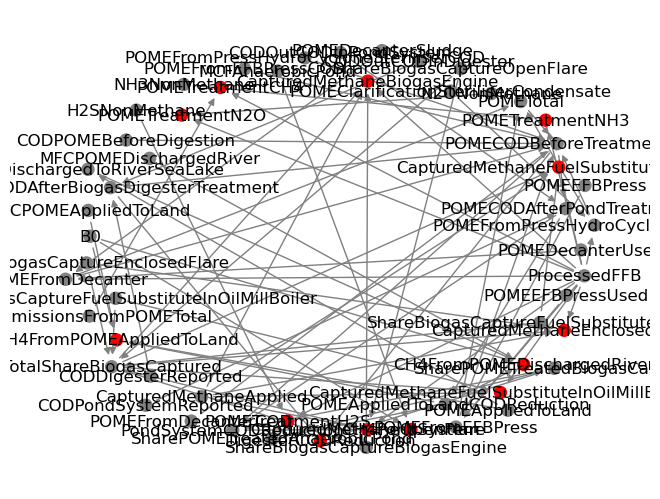

In [9]:
f2d_utils.draw_dag(dag)

check the connected components, usually there should be one (e.g. all connected)

In [11]:
dag_undirected =  nx.to_undirected(dag)
assert nx.number_connected_components(dag_undirected) == 1

display some stuff

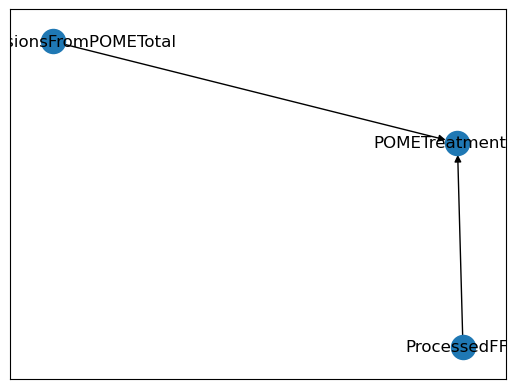

In [12]:
target_node = "POMETreatmentCH4"
adjacent_nodes = set(dag_undirected.neighbors(target_node))
adjacent_nodes.add(target_node) 
subgraph = dag.subgraph(adjacent_nodes)
nx.draw_networkx(subgraph)

In [13]:
# 'ends' of the graph
[node for node in dag.nodes if len(nx.descendants(dag,node))==0]

['CH4FromPOMEAppliedToLand',
 'CH4FromPOMEDischargedRiver',
 'CH4PondSystem',
 'CapturedMethaneBiogasEngine',
 'CapturedMethaneEnclosedFlare',
 'CapturedMethaneFuelSubstituteFuelOil',
 'CapturedMethaneFuelSubstituteInOilMillBoiler',
 'CapturedMethaneOpenFlare',
 'DigesterCODReduction',
 'POMETreatmentCH4',
 'POMETreatmentH2S',
 'POMETreatmentN2O',
 'POMETreatmentNH3']

In [14]:
# if python adaptation is completed, this should only 
# contain exogenous params to the model
input_params = {

'CapturedMethaneApplied':0.7, # calculated parameter!

'ShareBiogasCaptureBiogasEngine':0.47, # calculated!
'ShareBiogasCaptureEnclosedFlare':0.13, # calculated!
'ShareBiogasCaptureFuelSubstituteFuelOil':0.1, # calculated!
'ShareBiogasCaptureFuelSubstituteInOilMillBoiler':0, # calculated!
'ShareBiogasCaptureOpenFlare':0, # oil mills consolidate 19

'SharePOMETreatedAnaerobicPond':0.21417, # oil mills (calculated)

'CODOutCODInDigester':10/52, # Parameters E184

'CODOutCODInPondSystem':2.941/52, # calculated in Parameters E183
'CODPondSystemReported':0, # oil mills consolidate D31

# Parameters sheet
'B0':0.25, # 266 Parameters
'MFCPOMEAppliedToLand':0.05,
'MFCPOMEDischargedRiver':0.1,
'MCFAnaerobicPond':0.8,
'POMEDecanterSludge':-0.035,# E179 in 'Parameters'
'POMEEFBPress':0.140, # 174, parameters
'POMEClarificationSteriliserCondensate':0.53 + 0.12,
'POMEFromEFBPressCOD':210, # Parameters 181
'POMEFromDecanterCOD':380, # Parameters 182
'POMEFromPressHydroCycloneSteriliserCOD':79, # Parameters 180

# oil mill input
'ProcessedFFB':5644700.19, # D5 oil mill input
'POMEDecanterUsed':False, # oil mill input D11
'POMEEFBPressUsed':False, # oil mill input D10
'CODPOMEBeforeDigestion':0, # oil mill input D19
'CODDigesterReported':0, # oil mill input D20

# oil mill consolidate
"POMEAppliedToLand":1,# D26 in oil mill consolidate

# calculated parameters ! only here because the graph is incomplete
'CH4EmissionsFromPOMETotal':2.83173, # Calculated parameter ! E70 oil mill calc
'H2SNonMethane':0.00939661272035105,
'N2ONonMethane':0.000146169531205461,
'NH3NonMethane':0.00632009211116945,
}

In [15]:
missing = (set(f2d_utils.get_input_parameters(dag)).difference(input_params))
assert len(missing) == 0,missing

In [16]:
result_graph = f2d_utils.dirty_calc(module,
                                    dag,
                                    f2d_utils.order_dag(dag),
                                    input_data_dict=input_params)

In [17]:
calc_params = list(set(result_graph).difference(input_params))

In [18]:
order_dict = {value: index for index, value in enumerate(f2d_utils.order_dag(dag))}

In [19]:
calc_params = sorted(calc_params, key=lambda x: order_dict[x])

In [20]:
for node in calc_params:

    print(f"{node},{result_graph[node]:.2f}")

POMEDischargedToRiverSeaLake,0.00
TotalShareBiogasCaptured,0.70
SharePOMETreatedBiogasCapture,0.79
POMEFromDecanter,0.00
POMEFromEFBPress,0.00
POMEFromPressHydroCycloneSteriliser,0.65
POMETreatmentCH4,15984.27
POMETreatmentH2S,53.04
POMETreatmentN2O,0.83
POMETreatmentNH3,35.68
CapturedMethaneBiogasEngine,2653.01
CapturedMethaneEnclosedFlare,733.81
CapturedMethaneFuelSubstituteFuelOil,564.47
CapturedMethaneFuelSubstituteInOilMillBoiler,0.00
CapturedMethaneOpenFlare,0.00
POMETotal,0.65
POMECODBeforeTreatment,79.00
POMECODAfterBiogasDigesterTreatment,15.19
POMECODAfterPondTreatment,4.47
DigesterCODReduction,50.14
POMEAppliedToLandCODReduction,0.96
PondSystemCODReduction,15.96
CH4FromPOMEAppliedToLand,0.01
CH4FromPOMEDischargedRiver,0.00
CH4PondSystem,3.19
